In [3]:
import os
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [9]:
Features=pd.read_csv("../data/data_proccesed.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Y -= 1

# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [33]:
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
scheduler = LearningRateScheduler(custom_scheduler)

normalizer = layers.Normalization()
normalizer.adapt(X)

k=6
model = models.Sequential([
    layers.Input(shape=(x_train.shape[1], 1)),
    normalizer,
    # layers.Reshape((89, 2)),
    layers.Conv1D(2**(k+4), 1, activation='relu'),
    layers.Conv1D(2**(k+3), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k+2), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k+1), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(2**(k), 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(45, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [34]:
history=model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test),callbacks=scheduler)
model.save('../model')

Epoch 1/40
36/36 [==============================] - 8s 167ms/step - loss: 48978.5508 - accuracy: 0.1259 - val_loss: 1316.8303 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 2/40
36/36 [==============================] - 7s 189ms/step - loss: 436.7043 - accuracy: 0.0938 - val_loss: 5.6265 - val_accuracy: 0.1771 - lr: 0.0010
Epoch 3/40
36/36 [==============================] - 7s 204ms/step - loss: 3.6300 - accuracy: 0.1615 - val_loss: 2.2391 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 4/40
36/36 [==============================] - 7s 199ms/step - loss: 193.8513 - accuracy: 0.1927 - val_loss: 6.2392 - val_accuracy: 0.2153 - lr: 0.0010
Epoch 5/40
36/36 [==============================] - 7s 203ms/step - loss: 346.2853 - accuracy: 0.2101 - val_loss: 2.2032 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/40
36/36 [==============================] - 7s 198ms/step - loss: 2.0140 - accuracy: 0.2535 - val_loss: 1.8976 - val_accuracy: 0.2847 - lr: 0.0010
Epoch 7/40
36/36 [==============================] - 7s 19

INFO:tensorflow:Assets written to: ../model\assets


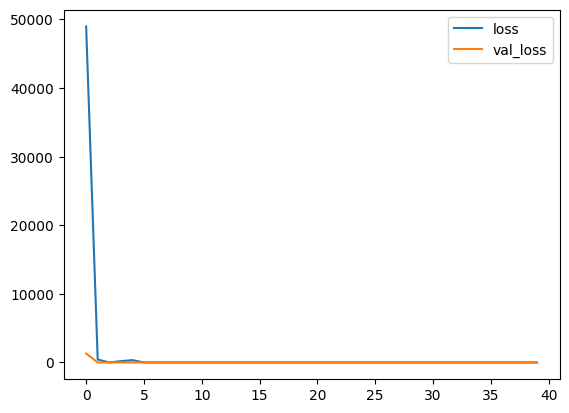

In [35]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

9/9 [==============================] - 1s 57ms/step
Test set accuracy: 30%


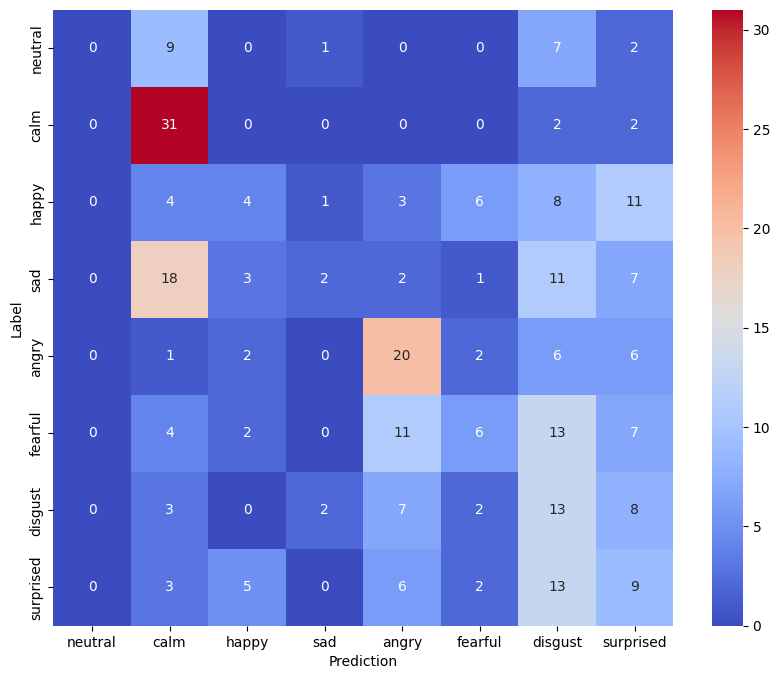

In [36]:
commands=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [30]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 0s 50ms/step - loss: 1.7192 - accuracy: 0.3125


[1.7192031145095825, 0.3125]